# Reconstruction of the upper-mid-ocean AMOC with the gridded mooring product form RAPID

This notebook will investige if there is there a linear correlation between the gridded mooring densities from RAPID and the upper_mid_ocean AMOC strength.
All salt and temeprature values are mapped to the insitu density and all NaN values are filled with zeros.
The resulting large dataset is decomposed with PCA into lower dimension.

For the linear prediction a MSE error is used togeteher with a L2-norm weight relgularization.

In [18]:
import xarray as xr
import gsw.density as density
import gsw.conversions as conversions
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge


In [19]:
#avoid the nan values in the beginning and the end of the time series
# We need to avoid dates later than mid of 2020 as the mooring data is not available
mooring_data = xr.open_dataset('data/ts_gridded.nc').sel(time = slice('2004-04-7', '2020-01-31'))
moc_data = xr.open_dataset('data/moc_transports.nc').sel(time = slice('2004-04-7', '2020-01-31'))

In [20]:
all_inputs = xr.concat([
    mooring_data.TG_west, mooring_data.SG_west,
    mooring_data.TG_east, mooring_data.SG_east,
    mooring_data.TG_wb3, mooring_data.SG_wb3,
    mooring_data.TG_marwest, mooring_data.SG_marwest,
    mooring_data.TG_mareast, mooring_data.SG_mareast,
], dim='depth').fillna(0).T

In [21]:
ct  = conversions.CT_from_pt(mooring_data.SG_west, mooring_data.TG_west)
rho_west = (density.rho(mooring_data.SG_west, ct, mooring_data.pressure) - 1000).fillna(0) 

ct  = conversions.CT_from_pt(mooring_data.SG_east, mooring_data.TG_east)
rho_east = (density.rho(mooring_data.SG_east, ct, mooring_data.pressure) - 1000).fillna(0)

ct  = conversions.CT_from_pt(mooring_data.SG_wb3, mooring_data.TG_wb3)
rho_wb3 = (density.rho(mooring_data.SG_wb3, ct, mooring_data.pressure) - 1000).fillna(0)

ct  = conversions.CT_from_pt(mooring_data.SG_marwest, mooring_data.TG_marwest)
rho_marwest = (density.rho(mooring_data.SG_marwest, ct, mooring_data.pressure) - 1000).fillna(0)

ct  = conversions.CT_from_pt(mooring_data.SG_mareast, mooring_data.TG_mareast)
rho_mareast = (density.rho(mooring_data.SG_mareast, ct, mooring_data.pressure) - 1000).fillna(0)

all_inputs = xr.concat([
    rho_west, rho_east, rho_wb3, rho_marwest, rho_mareast
], dim='depth').T

In [22]:
output = moc_data.t_umo10#.rolling(time=365*2, min_periods = 1).mean().fillna(0)

In [23]:

train_set = all_inputs.sel(time=slice('2004-01-01', '2014-12-31'))
test_set = all_inputs.sel(time=slice('2015-01-01', None))

train_output = output.sel(time=slice('2004-01-01', '2014-12-31'))
test_output = output.sel(time=slice('2015-01-01', None))

In [25]:
pca = PCA(n_components=1000)
pca.fit(train_set.values)

print(np.cumsum(pca.explained_variance_ratio_)[-1:])

[1.]


In [26]:
transformed_train_input = pca.transform(train_set.values)
transformed_test_input = pca.transform(test_set.values)

In [27]:
from sklearn.neural_network import MLPRegressor


mlp_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000).fit(transformed_train_input, train_output.values)
mlp_model.score(transformed_test_input[:], test_output.values[:])

-32.807281176350244

(-30.0, 0.0)

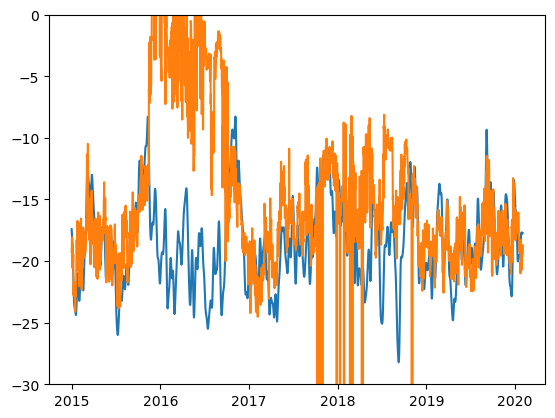

In [28]:
#plot the results
plt.plot(test_output.time, test_output)
plt.plot(test_output.time[:],mlp_model.predict(transformed_test_input[:]))

plt.ylim(-30, 0)

(-30.0, -5.0)

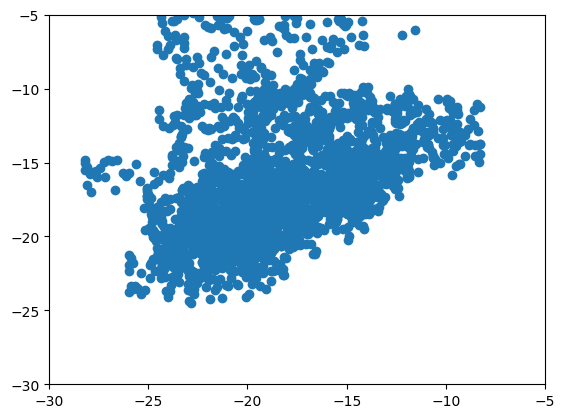

In [32]:

valuable_prediction_mask = mlp_model.predict(transformed_test_input[:]) > -100

plt.scatter(test_output[valuable_prediction_mask],mlp_model.predict(transformed_test_input[valuable_prediction_mask]))
plt.ylim(-30,-5)
plt.xlim(-30,-5)


The rconstruction works with MLP regressor 2 hidden layer with 100 neurons each on the RAPID data okish. 

In case of a random split between the training and testing data the reconstruction is well trained with R2 scores up to: 92% with a great performance.
Using yearly smoothed AMOC the results are still ok with R2 score of 97%. Probably due to the smoothing there is a leaking such that the performance even increased.

But with a sequential split of training and testing this advantages disappears. The RAPID data ranges from 2004 to 2022 and if we do a split at 1/1/2018 with daily AMOC data the results are twofold.
In the period before 07/2020 the reconstruction is ok with the exception of a date in 2019. 
It seems that the data contains a different structure of the mooring data that can not be well generalized by the data.

For the yearly smoothed AMOC the R2 score from 1/1/2018 to 1/1/2020 is -2.18 because the curve is not well matched even not the longterm.

With the short scales the AMOC and some outlier removal the score is still around 40%. But in this case we removed the last two years as they are completely off and inbetween some predictions that have -200 Sv.

#### Improvements

The mooring can be different along the time resulting in wrong values we need to check if this is the case starting from the second half of 2020.


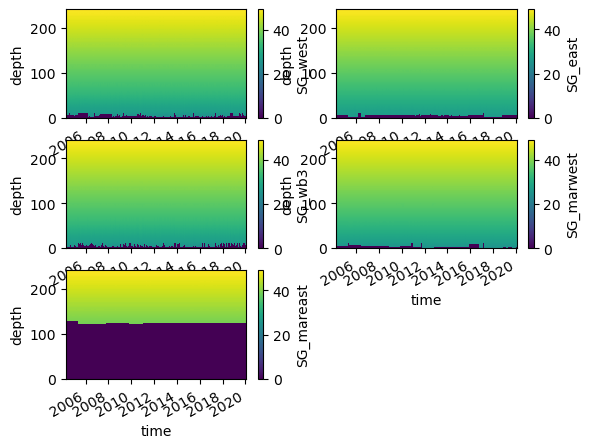

In [30]:
fig = plt.figure()
ax = fig.add_subplot(3,2,1)
rho_west.plot(ax=ax)

ax = fig.add_subplot(3,2,2)
rho_east.plot(ax=ax)

ax = fig.add_subplot(3,2,3)
rho_wb3.plot(ax=ax)

ax = fig.add_subplot(3,2,4)
rho_marwest.plot(ax=ax)

ax = fig.add_subplot(3,2,5)
rho_mareast.plot(ax=ax)



We cutted away the mooring date later than 2020 as there were three mooring with missing data.
Now we train from 2004-2014 and test on the rest. Suprisignly the results are worse -3250% R2 scores.
I think that is a problem with non existing dropout so lets try this.

In [33]:
import torch


ModuleNotFoundError: No module named 'torch'